## Plot mutation prediction results

In this notebook, we'll compare the results of our mutation prediction experiments for expression and methylation data only (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)
* PLOT_AUROC (bool): if True plot AUROC, else plot AUPR

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['mutation'],
                   'methylation_results_shuffle_cancer_type',
                   'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = True

# if True, plot AUROC instead of AUPR
PLOT_AUROC = False
if PLOT_AUROC:
    plot_metric = 'auroc'
    images_dir = Path(cfg.images_dirs['mutation'], 'auroc')
else:
    plot_metric = 'aupr'
    images_dir = Path(cfg.images_dirs['mutation'])

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
results_df = results_df[results_df.training_data.isin(['expression'])].copy()

print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(4032, 9)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.99936,0.99278,MAP3K1,expression,signal,42,train,0,gene
1,0.59870,0.14903,MAP3K1,expression,signal,42,test,0,gene
2,0.66496,0.20677,MAP3K1,expression,signal,42,cv,0,gene
3,0.99468,0.91588,MAP3K1,expression,signal,42,train,1,gene
4,0.75569,0.40224,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
compressed_results_df = au.load_compressed_prediction_results(results_dir, 'gene',
                                                              old_filenames=True)
compressed_results_df = compressed_results_df[
    (compressed_results_df.training_data.isin(['me_27k', 'me_450k'])) &
    (compressed_results_df.n_dims == 5000)
].copy()
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
print(compressed_results_df.n_dims.unique())
print(compressed_results_df.shape)
compressed_results_df.head()

[ 1 42]
['me_450k' 'me_27k']
[5000]
(8064, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.60644,0.17261,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.62170,0.24357,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.58918,0.23904,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
results_df['n_dims'] = 'raw'
results_df = pd.concat((results_df, compressed_results_df))
print(results_df.seed.unique())
print(results_df.training_data.unique())
print(results_df.n_dims.unique())
print(results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
}
results_df.training_data.replace(to_replace=training_data_map, inplace=True)
results_df.head()

[42  1]
['expression' 'me_450k' 'me_27k']
['raw' 5000]
(12096, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.99936,0.99278,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.59870,0.14903,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.66496,0.20677,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.99468,0.91588,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.75569,0.40224,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [6]:
all_results_df = au.compare_all_data_types(results_df,
                                           SIG_ALPHA,
                                           metric=plot_metric)

all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
18,CDKN2A,0.242739,4.577075e-09,1.937526e-07,True,450k methylation,6.712752
81,TP53,0.241325,4.613157e-09,1.937526e-07,True,450k methylation,6.712752
81,TP53,0.225365,5.810411e-09,2.368649e-07,True,gene expression,6.625499
69,PTEN,0.367166,7.936128e-09,2.368649e-07,True,gene expression,6.625499
24,EGFR,0.568070,8.459462e-09,2.368649e-07,True,gene expression,6.625499
17,CDH1,0.255346,1.395460e-08,6.172949e-07,True,27k methylation,6.209507
81,TP53,0.212923,1.469750e-08,6.172949e-07,True,27k methylation,6.209507
18,CDKN2A,0.258989,1.608797e-08,3.378473e-07,True,gene expression,6.471280
62,NRAS,0.376399,2.000726e-08,5.602033e-07,True,450k methylation,6.251654
69,PTEN,0.255535,3.239388e-08,9.070286e-07,True,27k methylation,6.042379


gene expression: 40/84
27k methylation: 38/84
450k methylation: 37/84


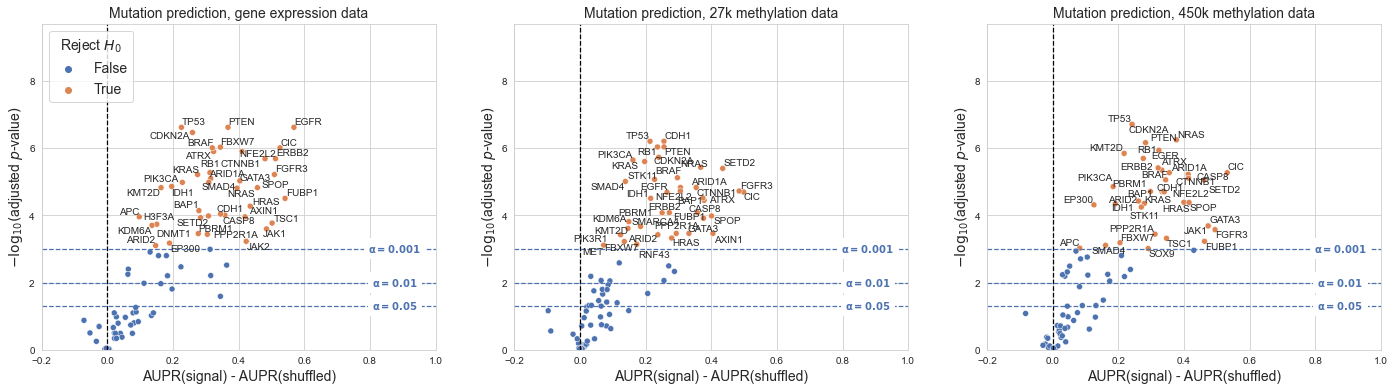

In [7]:
sns.set({'figure.figsize': (24, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          training_data_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True)
    
if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'methylation_vs_shuffled.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_vs_shuffled.png',
                dpi=300, bbox_inches='tight')

In [8]:
# map gene/training data combinations to accept/reject null
# vs. shuffled baseline
# we want to plot this info on top of -omics comparison
id_to_sig = (all_results_df
  .loc[:, ['gene', 'training_data', 'reject_null']]
  .rename(columns={'reject_null': 'reject_null_baseline'})
)

id_to_sig.head()

,gene,training_data,reject_null_baseline
0,ABL1,gene expression,False
1,ALK,gene expression,False
2,AMER1,gene expression,False
3,APC,gene expression,True
4,ARID1A,gene expression,True


27k methylation: 5/84
450k methylation: 3/84


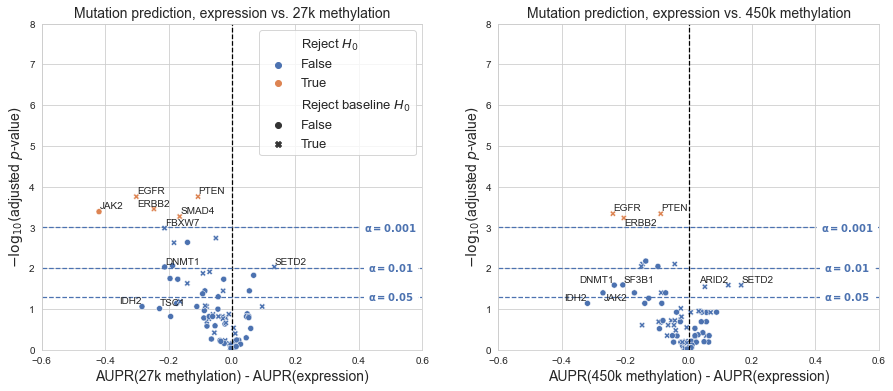

In [9]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (15, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)


plu.plot_volcano_comparison(results_df,
                            axarr,
                            training_data_map,
                            SIG_ALPHA,
                            metric=plot_metric,
                            xlim=(-0.6, 0.6),
                            sig_genes=id_to_sig,
                            verbose=True)

if SAVE_FIGS:
    plt.savefig(images_dir / 'methylation_comparison.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_comparison.png',
                dpi=300, bbox_inches='tight')

(46,)
['APC' 'ARID1A' 'ARID2' 'ATRX' 'AXIN1' 'BAP1' 'BRAF' 'CASP8' 'CDH1'
 'CDKN2A' 'CIC' 'CTNNB1' 'DNMT1' 'EGFR' 'EP300' 'ERBB2' 'FBXW7' 'FGFR3'
 'FUBP1' 'GATA3' 'H3F3A' 'HRAS' 'IDH1' 'JAK1' 'JAK2' 'KDM6A' 'KMT2D'
 'KRAS' 'NFE2L2' 'NRAS' 'PBRM1' 'PIK3CA' 'PPP2R1A' 'PTEN' 'RB1' 'SETD2'
 'SMAD4' 'SPOP' 'TP53' 'TSC1' 'SOX9' 'STK11' 'MET' 'PIK3R1' 'RNF43'
 'SMARCA4']


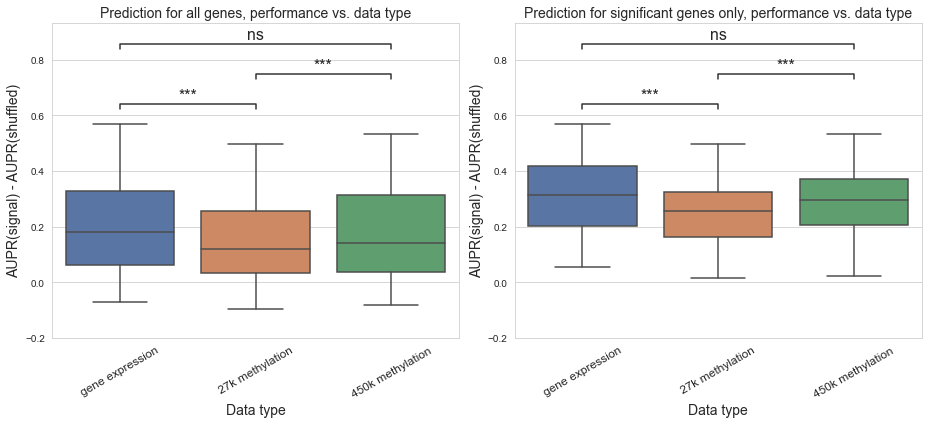

In [10]:
sns.set({'figure.figsize': (13, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

tests_df = plu.plot_boxes(all_results_df,
                          axarr,
                          training_data_map,
                          metric=plot_metric,
                          verbose=True,
                          pairwise_tests=True,
                          pairwise_box_pairs=[('gene expression', '27k methylation'),
                                              ('27k methylation', '450k methylation'),
                                              ('gene expression', '450k methylation')])

if SAVE_FIGS:
    plt.savefig(images_dir / 'methylation_best_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_best_boxes.png',
                dpi=300, bbox_inches='tight')

In [11]:
# pairwise rank sum tests comparing results distributions
# H0: results distributions are the same between the data types
tests_df.sort_values(['gene_set', 'p_value'])

,data_type_1,data_type_2,p_value,corr_pval,reject_null,gene_set
2,27k methylation,450k methylation,0.000029,0.000088,True,all
0,gene expression,27k methylation,0.000038,0.000115,True,all
1,gene expression,450k methylation,0.027901,0.083704,False,all
2,27k methylation,450k methylation,0.000005,0.000015,True,significant
0,gene expression,27k methylation,0.000280,0.000841,True,significant
1,gene expression,450k methylation,0.130238,0.390714,False,significant


In [12]:
heatmap_df = (all_results_df
    .pivot(index='training_data', columns='gene', values='delta_mean')
    .reindex(training_data_map.values())
)
heatmap_df.iloc[:, :5]

gene,ABL1,ALK,AMER1,APC,ARID1A
training_data,,,,,
gene expression,0.005519,0.021273,-0.025538,0.096825,0.314699
27k methylation,0.019987,0.068767,0.041823,0.090727,0.305634
450k methylation,-0.022497,0.009859,0.046619,0.082084,0.354936


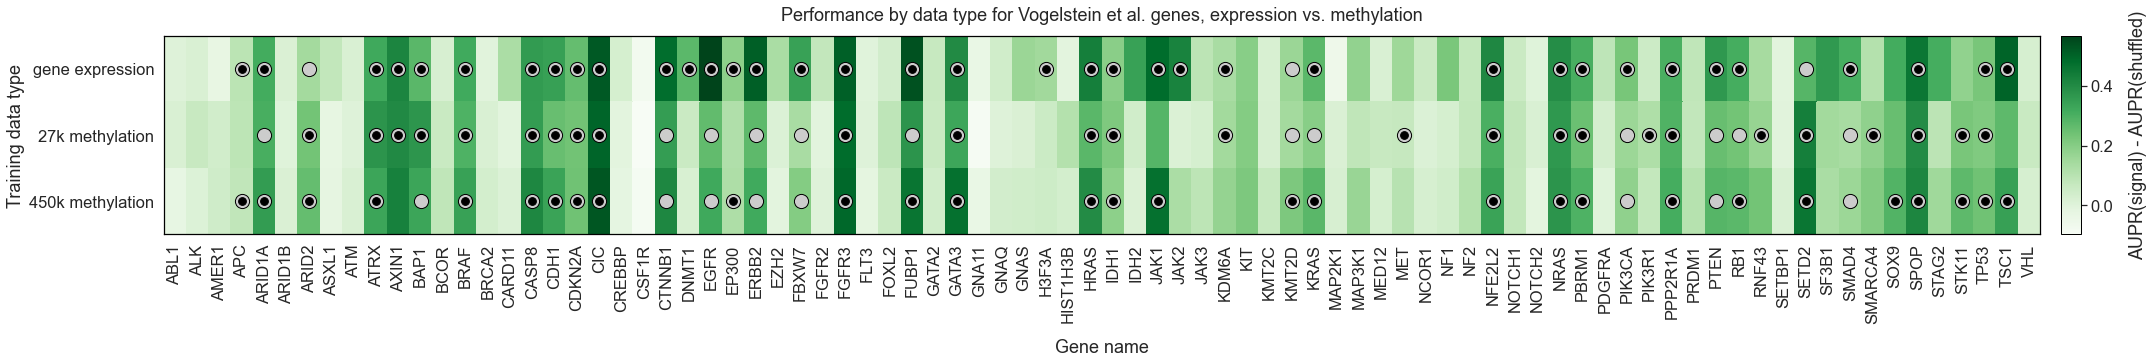

In [13]:
sns.set({'figure.figsize': (32, 5)})
sns.set_context('notebook', font_scale=1.5)

ax = plu.plot_heatmap(heatmap_df,
                      all_results_df.reset_index(drop=True),
                      results_df,
                      metric=plot_metric,
                      origin_eps_x=0.02,
                      origin_eps_y=0.015,
                      length_x=0.85,
                      length_y=0.95)

plt.title('Performance by data type for Vogelstein et al. genes, expression vs. methylation', pad=15)

if SAVE_FIGS:
    plt.savefig(images_dir / 'methylation_heatmap.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'methylation_heatmap.png',
                dpi=300, bbox_inches='tight')

Key to above heatmap:

* A grey dot = significantly better than label-permuted baseline, but significantly worse than best-performing data type
* A grey dot with black dot inside = significantly better than label-permuted baseline, and not significantly different from best-performing data type (i.e. "statistically equivalent to best")
* No dot = not significantly better than label-permuted baseline